# Trabalho Prático 3

## Grupo 04 - Renato Garcia (A101987) & Bernardo Moniz (A102497)

## Problema 2
### Enunciado

Relativo ao programa do problema anterior,

a. Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos. 

b. Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema.
    
> sugere-se (não é obrigatório mas é valorizado !), na alínea (a), uma representação do CFA através de  um grafo orientado  implementado  em `networkx`  e a sua compilação para o sistema de equações.

### Resolução

Para a realização deste problema, começamos por criar um grafo orientado que representa o Control Flow Automaton (CFA) do programa. Este grafo é composto por nós que representam os locais do programa e por ramos que representam os "switches" entre esses locais.

Também temos o sistema de equações, abaixo do esboço do CFA, que representa o comportamento do sistema dinâmico sob o ponto de vista da prova de segurança.

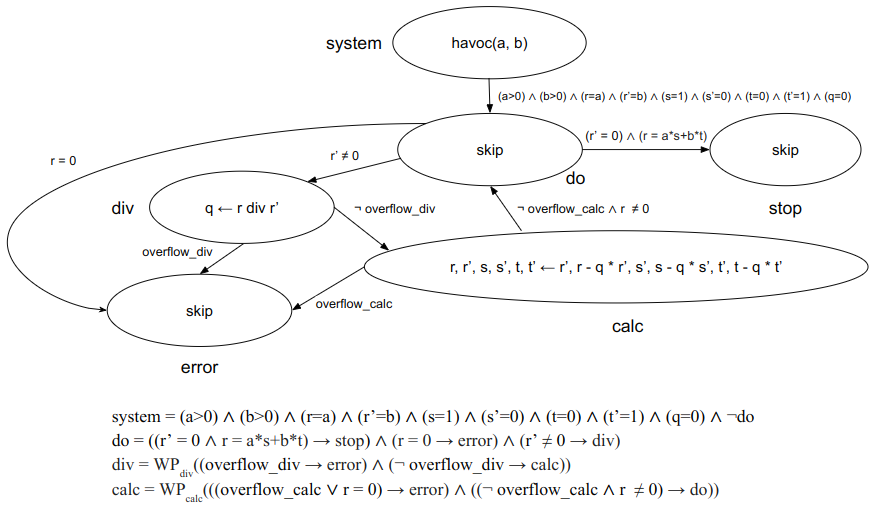

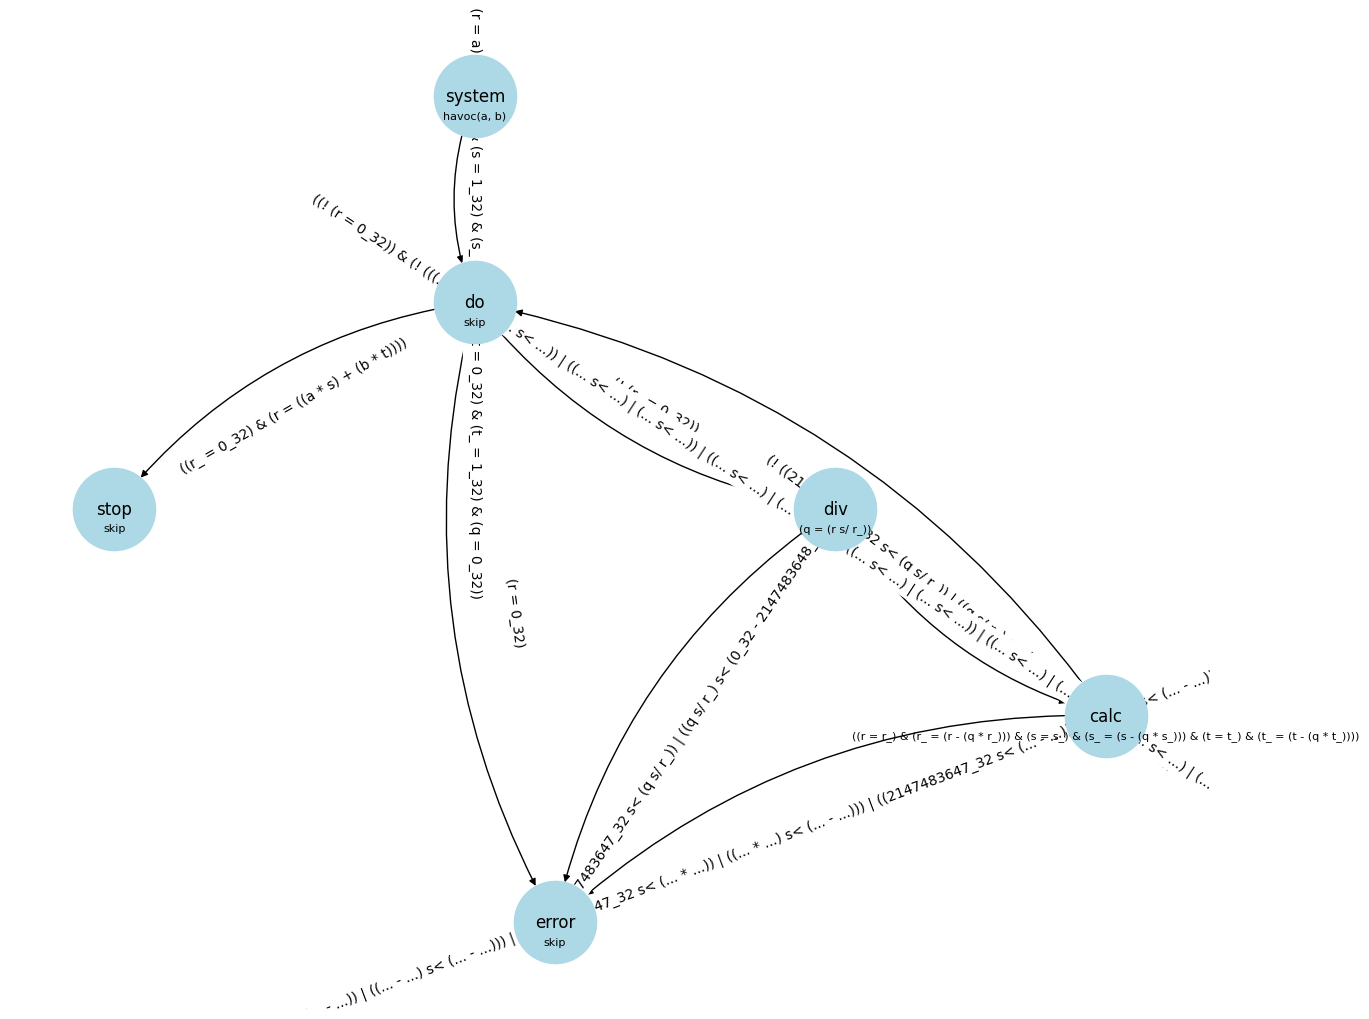

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import BVType
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

bits = 32
Max_value = BV((1 << (bits - 1)) - 1, bits)
Min_value = BV(0, bits) - BV(1 << (bits - 1), bits)

a = Symbol("a", BVType(bits))
b = Symbol("b", BVType(bits))
r = Symbol("r", BVType(bits))
r_ = Symbol("r_", BVType(bits))
s = Symbol("s", BVType(bits))
s_ = Symbol("s_", BVType(bits))
t = Symbol("t", BVType(bits))
t_ = Symbol("t_", BVType(bits))
q = Symbol("q", BVType(bits))

# Nodes: label-annotation tuples.
nodes = [
         ("system", "havoc(a, b)"),
         ("do", "skip"),
         ("error", "skip"),
         ("stop", "skip"),
         ("div", Equals(q, BVSDiv(r, r_))),
         ("calc", And(
          Equals(r, r_), 
          Equals(r_, BVSub(r, BVMul(q, r_))),
          Equals(s, s_),
          Equals(s_, BVSub(s, BVMul(q, s_))),
          Equals(t, t_),
          Equals(t_, BVSub(t, BVMul(q, t_)))
         ))
        ]

overflow_div = Or (
    BVSGT(BVSDiv(q, r_), Max_value), 
    BVSLT(BVSDiv(q, r_), Min_value)
)

overflow_calc = Or(
    Or(
        BVSGT(BVMul(q, r_), Max_value), 
        BVSLT(BVMul(q, r_), Min_value)
    ),
    
    Or(
        BVSGT(BVSub(r, BVMul(q, r_)), Max_value), 
        BVSLT(BVSub(r, BVMul(q, r_)), Min_value)
    ),
    
    Or(
        BVSGT(BVMul(q, s_), Max_value), 
        BVSLT(BVMul(q, s_), Min_value)
    ),
    
    Or(
        BVSGT(BVSub(s, BVMul(q, s_)), Max_value), 
        BVSLT(BVSub(s, BVMul(q, s_)), Min_value)
    ),
    
    Or(
        BVSGT(BVMul(q, t_), Max_value), 
        BVSLT(BVMul(q, t_), Min_value)
    ),
    
    Or(
        BVSGT(BVSub(t, BVMul(q, t_)), Max_value), 
        BVSLT(BVSub(t, BVMul(q, t_)), Min_value)
    )
)

# Edges: source-target-condition tuples.
edges = [
         ("system", "do", And(
             BVSGT(a, BV(0, bits)), BVSGT(b, BV(0, bits)),
             Equals(r, a), Equals(r_, b),
             Equals(s, BV(1, bits)), Equals(s_, BV(0, bits)),
             Equals(t, BV(0, bits)), Equals(t_, BV(1, bits)),
             Equals(q, BV(0, bits)))
          ),
         ("do", "stop", And(Equals(r_, BV(0, bits)), Equals(r, BVAdd(BVMul(a, s), BVMul(b, t))))),
         ("do", "error", Equals(r, BV(0, bits))),
         ("do", "div", Not(Equals(r_, BV(0, bits)))),
         ("div", "calc", Not(overflow_div)),
         ("div", "error", overflow_div),
         ("calc", "do", And(Not(Equals(r, BV(0, bits))), Not(overflow_calc))),  
         ("calc", "error", Or(Equals(r, BV(0, bits)), overflow_calc))
        ]

for label, annotation in nodes:
    G.add_node(label, annotation = annotation)

for source, target, condition in edges:
    G.add_edge(source, target, condition = condition)
    
pos = nx.nx_pydot.pydot_layout(G, prog="dot")
plt.figure(figsize=(12, 10))
nx.draw(G, pos = pos, with_labels = True, node_size = 3500, connectionstyle="arc3,rad=0.2", node_color = 'lightblue')

edge_conds = nx.get_edge_attributes(G, name = "condition")
nx.draw_networkx_edge_labels(G, pos, edge_conds)

annotations = nx.get_node_attributes(G, 'annotation')
for node, annotation in annotations.items():
    xp, yp = pos[node]
    plt.text(xp, yp - 5, annotation, fontsize=8, ha='center', va='top')

plt.show()

In [2]:
def graph_safety(G, n, N):
    print(f"> A testar {n} iterações.")

    with Solver(name="z3") as solver:
        r = Symbol("r", BVType(N))
        r_ = Symbol("r_", BVType(N))
        s = Symbol("s", BVType(N))
        s_ = Symbol("s_", BVType(N))
        t = Symbol("t", BVType(N))
        t_ = Symbol("t_", BVType(N))
        q = Symbol("q", BVType(N))

        error = TRUE()  
        stop = FALSE()  
        
        do = FALSE() 

        for source, target, data in G.edges(data=True):
            if source == "system" and target == "do":
                guarda = data["condition"]

        for i in range(n):
            system = And(guarda, do)
            if solver.solve([system]):
                print(f"> Iteração {i}: sistema inseguro.")
                return

            clauses = []
            for source, target, data in G.edges(data=True):
                if source == "do":
                    condition = data["condition"]
                    
                    if target == "error":
                        clauses.append(Implies(condition, error))
                        
                    elif target == "stop":
                        clauses.append(Implies(condition, stop))
                        
                    elif target == "div":
                        sub = {q: BVSDiv(r, r_)}
                        new_do = substitute(do, sub)
                        clauses.append(Implies(condition, new_do))
                        
                    elif target == "calc":
                        sub = {
                            r: r_,
                            r_: BVSub(r, BVMul(q, r_)),
                            s: s_,
                            s_: BVSub(s, BVMul(q, s_)),
                            t: t_,
                            t_: BVSub(t, BVMul(q, t_)),
                        }
                        new_do = substitute(do, sub)
                        clauses.append(Implies(condition, new_do))

            new_do = And(clauses)

            # Tentar generalizar.
            R = And(do, Not(new_do))
            L = And(new_do, Not(do))
            if solver.is_unsat(Or(R, L)):
                # do_n <-> do_{n-1}
                print(f"> Iteração {i}: sistema seguro.")
                return

            do = Or(do, new_do)

        print("> Não foram encontrados estados inseguros ou condição alcançada.")

In [3]:
graph_safety(G, 10, bits)

> A testar 10 iterações.
> Iteração 1: sistema seguro.
